In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.metrics import precision_recall_curve

## Tập dữ liệu tiếng Anh

In [2]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

In [3]:
fake_df.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake_df.shape

(23481, 4)

In [5]:
true_df.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
true_df.shape

(21417, 4)

In [7]:
print("Fake News Dataset Information:")
print(fake_df.info())

Fake News Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None


In [8]:
print("\nTrue News Dataset Information:")
print(true_df.info())


True News Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [9]:
print("\nMissing values in Fake News Dataset:")
print(fake_df.isnull().sum())



Missing values in Fake News Dataset:
title      0
text       0
subject    0
date       0
dtype: int64


In [10]:
print("\nMissing values in True News Dataset:")
print(true_df.isnull().sum())


Missing values in True News Dataset:
title      0
text       0
subject    0
date       0
dtype: int64


In [11]:
fake_df.fillna('', inplace=True)
true_df.fillna('', inplace=True)

In [12]:
fake_df['label'] = 1
true_df['label'] = 0

In [13]:
df = pd.concat([fake_df, true_df])

In [14]:
print("\nClass distribution in the combined dataset:")
print(df['label'].value_counts())


Class distribution in the combined dataset:
label
1    23481
0    21417
Name: count, dtype: int64


In [15]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

In [16]:
df['text_combined'] = df['title'] + ' ' + df['text']
df['text_combined'] = df['text_combined'].apply(preprocess_text)

In [17]:
print("\n5 hàng đầu tiên của bộ dữ liệu đã làm sạch:")
print(df[['text_combined', 'label']].head())


5 hàng đầu tiên của bộ dữ liệu đã làm sạch:
                                       text_combined  label
0   donald trump sends out embarrassing new year’...      1
1   drunk bragging trump staffer started russian ...      1
2   sheriff david clarke becomes an internet joke...      1
3   trump is so obsessed he even has obama’s name...      1
4   pope francis just called out donald trump dur...      1


In [18]:
# So sánh các bộ dữ liệu
print("\nPhân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Giả:")
print(fake_df['subject'].value_counts())
print("\nPhân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Thật:")
print(true_df['subject'].value_counts())


Phân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Giả:
subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

Phân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Thật:
subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64


In [19]:

print("\nPhân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Thật:")
print(true_df['subject'].value_counts())



Phân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Thật:
subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64


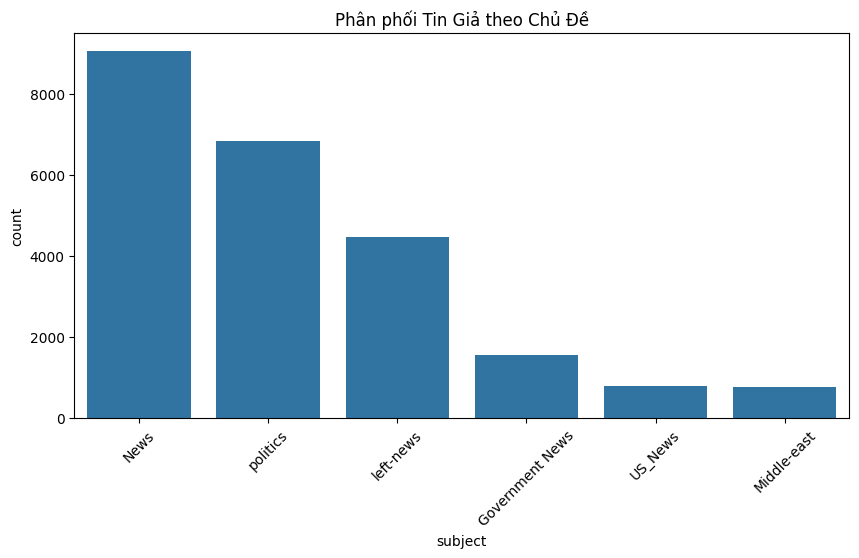

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(x='subject', data=fake_df, order=fake_df['subject'].value_counts().index)
plt.title('Phân phối Tin Giả theo Chủ Đề')
plt.xticks(rotation=45)
plt.show()

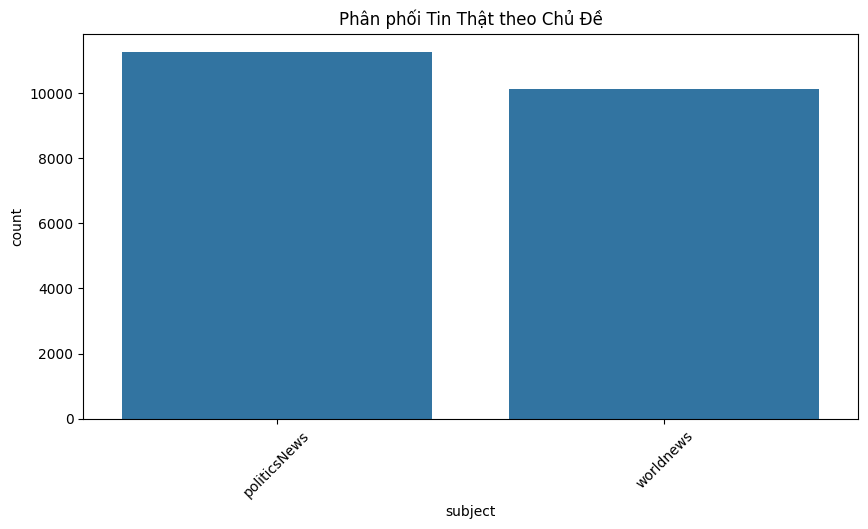

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(x='subject', data=true_df, order=true_df['subject'].value_counts().index)
plt.title('Phân phối Tin Thật theo Chủ Đề')
plt.xticks(rotation=45)
plt.show()

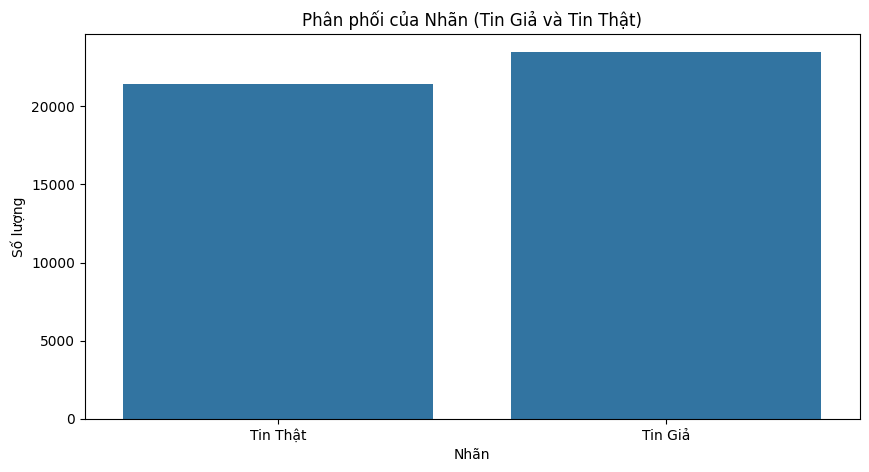

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df)
plt.title('Phân phối của Nhãn (Tin Giả và Tin Thật)')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks([0, 1], ['Tin Thật', 'Tin Giả'])
plt.show()

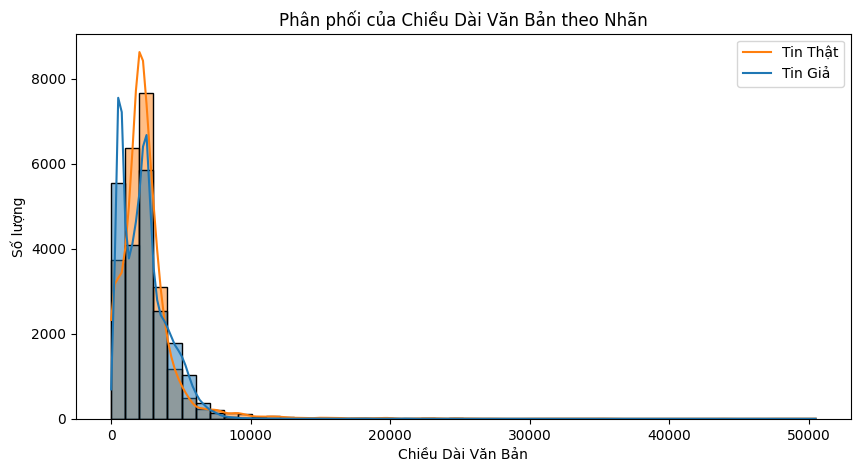

In [23]:
df['text_length'] = df['text_combined'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Phân phối của Chiều Dài Văn Bản theo Nhãn')
plt.xlabel('Chiều Dài Văn Bản')
plt.ylabel('Số lượng')
plt.legend(['Tin Thật', 'Tin Giả'])
plt.show()

In [24]:
X = df['text_combined']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
vectorizer = TfidfVectorizer(max_df=0.7, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [26]:
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=200)

In [27]:
y_pred = model.predict(X_test_tfidf)
print(f'Độ chính xác: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Độ chính xác: 0.9840757238307349
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4247
           1       0.98      0.99      0.98      4733

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



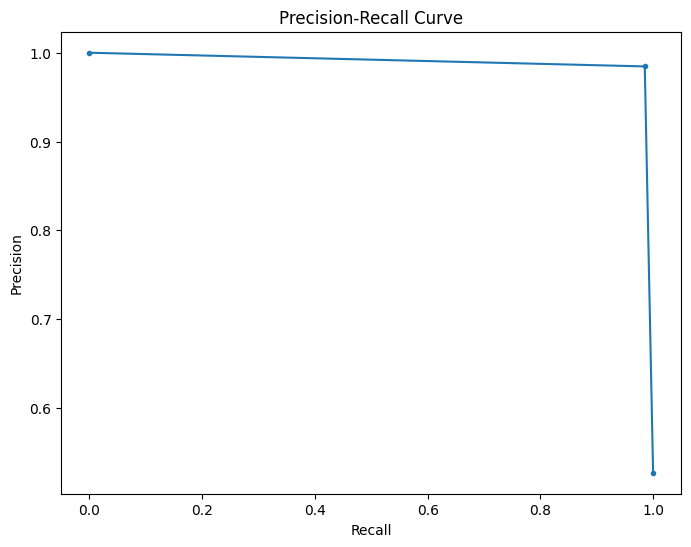

In [28]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [29]:
joblib.dump(model, 'fake_news_detector_en.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer_en.pkl')

['tfidf_vectorizer_en.pkl']

## Tập dữ liệu tiếng Việt

In [30]:
fake_vi_df = pd.read_csv('Fake_vi.csv')
true_vi_df = pd.read_csv('True_vi.csv')

In [31]:
fake_vi_df.head(5)

,title,text,subject,date
0,Donald Trump gửi thông điệp đêm giao thừa đáng...,Donald Trump không thể chúc tất cả người Mỹ mộ...,News,31-Dec-17
1,Nhân viên Trump say rượu khoe khoang bắt đầu ...,Chủ tịch Ủy ban Tình báo Hạ viện Devin Nunes s...,News,31-Dec-17
2,Cảnh sát trưởng David Clarke trở thành trò đù...,"Vào thứ Sáu, có thông tin tiết lộ rằng cựu Cản...",News,30-Dec-17
3,Trump bị ám ảnh đến mức thậm chí còn mã hóa t...,"Vào ngày Giáng sinh, Donald Trump thông báo rằ...",News,29-Dec-17
4,Giáo hoàng Francis vừa gọi tên Donald Trump t...,Đức Thánh Cha Phanxicô đã sử dụng thông điệp N...,News,25-Dec-17


In [32]:
fake_vi_df.shape

(499, 4)

In [33]:
true_vi_df.head(5)

,title,text,subject,date
0,"Khi cuộc chiến ngân sách Hoa Kỳ sắp xảy ra, Đả...",WASHINGTON (Reuters) - Người đứng đầu phe Cộng...,politicsNews,31-Dec-17
1,Quân đội Mỹ tiếp nhận tân binh chuyển giới vào...,WASHINGTON (Reuters) – Người chuyển giới sẽ đư...,politicsNews,29-Dec-17
2,Thượng nghị sĩ cấp cao Đảng Cộng hòa Hoa Kỳ: '...,WASHINGTON (Reuters) - Cuộc điều tra của công ...,politicsNews,31-Dec-17
3,Cuộc điều tra của FBI Nga được sự giúp đỡ của ...,WASHINGTON (Reuters) - Cố vấn chiến dịch tranh...,politicsNews,30-Dec-17
4,Trump muốn Bưu điện tính phí 'nhiều hơn nữa' c...,SEATTLE / WASHINGTON (Reuters) - Tổng thống Do...,politicsNews,29-Dec-17


In [34]:
true_vi_df.shape

(499, 4)

In [35]:
print("Fake News Dataset Information:")
print(fake_vi_df.info())

Fake News Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    499 non-null    object
 1   text     499 non-null    object
 2   subject  499 non-null    object
 3   date     499 non-null    object
dtypes: object(4)
memory usage: 15.7+ KB
None


In [36]:
print("\nTrue News Dataset Information:")
print(true_vi_df.info())


True News Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    499 non-null    object
 1   text     499 non-null    object
 2   subject  499 non-null    object
 3   date     499 non-null    object
dtypes: object(4)
memory usage: 15.7+ KB
None


In [37]:
print("\nMissing values in Fake News Dataset:")
print(fake_vi_df.isnull().sum())



Missing values in Fake News Dataset:
title      0
text       0
subject    0
date       0
dtype: int64


In [38]:
print("\nMissing values in True News Dataset:")
print(true_vi_df.isnull().sum())


Missing values in True News Dataset:
title      0
text       0
subject    0
date       0
dtype: int64


In [39]:
fake_vi_df.fillna('', inplace=True)
true_vi_df.fillna('', inplace=True)

In [40]:
fake_vi_df['label'] = 1
true_vi_df['label'] = 0

In [41]:
df_vi = pd.concat([fake_vi_df, true_vi_df])

In [42]:
print("\nClass distribution in the combined dataset:")
print(df_vi['label'].value_counts())


Class distribution in the combined dataset:
label
1    499
0    499
Name: count, dtype: int64


In [43]:
def preprocess_text_vi(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

In [44]:
df_vi['text_combined'] = df_vi['title'] + ' ' + df_vi['text']
df_vi['text_combined'] = df_vi['text_combined'].apply(preprocess_text_vi)

In [45]:
print("\n5 hàng đầu tiên của bộ dữ liệu đã làm sạch:")
print(df_vi[['text_combined', 'label']].head())


5 hàng đầu tiên của bộ dữ liệu đã làm sạch:
                                       text_combined  label
0  donald trump gửi thông điệp đêm giao thừa đáng...      1
1   nhân viên trump say rượu khoe khoang bắt đầu ...      1
2   cảnh sát trưởng david clarke trở thành trò đù...      1
3   trump bị ám ảnh đến mức thậm chí còn mã hóa t...      1
4   giáo hoàng francis vừa gọi tên donald trump t...      1


In [46]:
# So sánh các bộ dữ liệu
print("\nPhân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Giả:")
print(fake_vi_df['subject'].value_counts())
print("\nPhân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Thật:")
print(true_vi_df['subject'].value_counts())


Phân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Giả:
subject
News    499
Name: count, dtype: int64

Phân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Thật:
subject
politicsNews    499
Name: count, dtype: int64


In [47]:

print("\nPhân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Thật:")
print(true_vi_df['subject'].value_counts())



Phân phối tin tức theo chủ đề trong Bộ Dữ Liệu Tin Thật:
subject
politicsNews    499
Name: count, dtype: int64


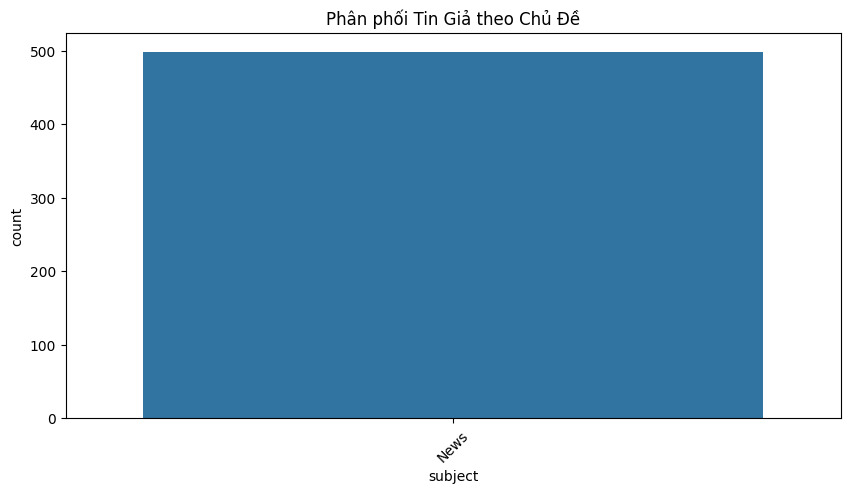

In [48]:
plt.figure(figsize=(10, 5))
sns.countplot(x='subject', data=fake_vi_df, order=fake_vi_df['subject'].value_counts().index)
plt.title('Phân phối Tin Giả theo Chủ Đề')
plt.xticks(rotation=45)
plt.show()

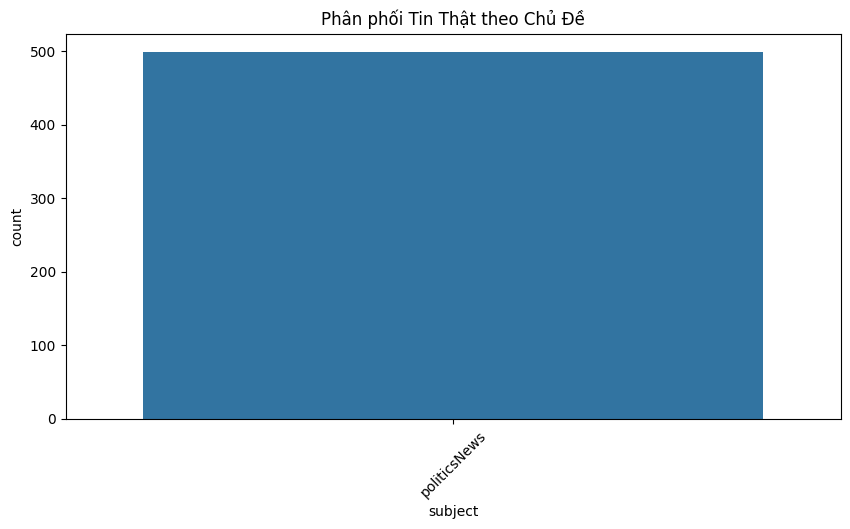

In [49]:
plt.figure(figsize=(10, 5))
sns.countplot(x='subject', data=true_vi_df, order=true_vi_df['subject'].value_counts().index)
plt.title('Phân phối Tin Thật theo Chủ Đề')
plt.xticks(rotation=45)
plt.show()

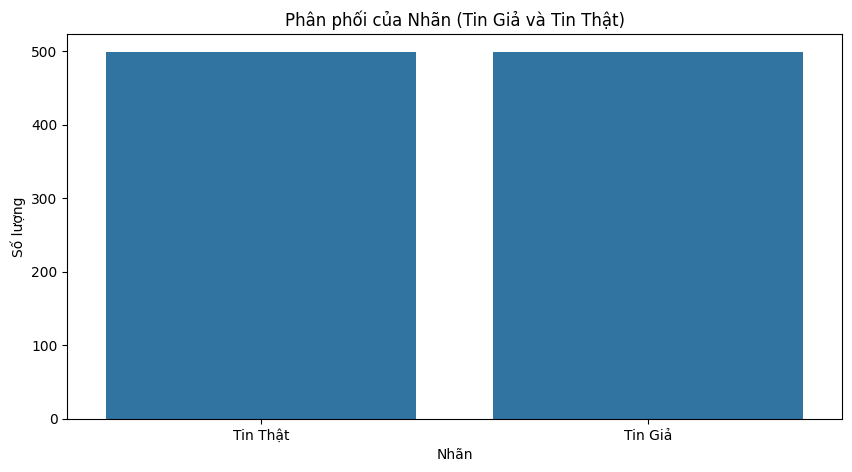

In [50]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df_vi)
plt.title('Phân phối của Nhãn (Tin Giả và Tin Thật)')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks([0, 1], ['Tin Thật', 'Tin Giả'])
plt.show()

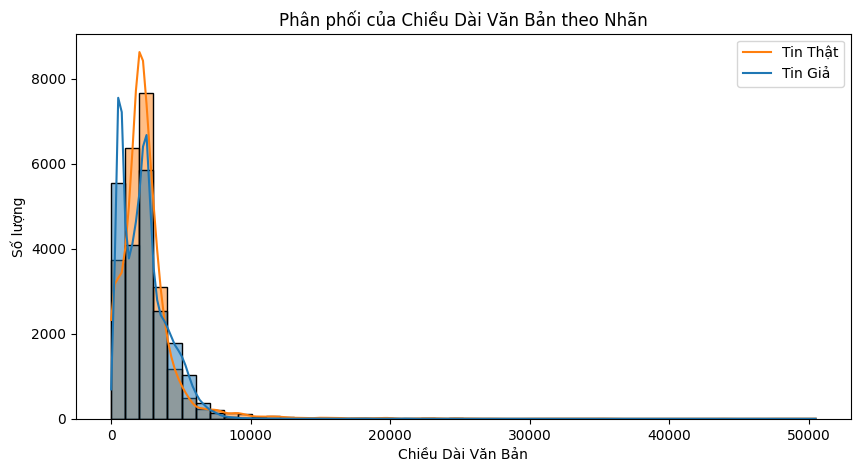

In [51]:
df_vi['text_length'] = df_vi['text_combined'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Phân phối của Chiều Dài Văn Bản theo Nhãn')
plt.xlabel('Chiều Dài Văn Bản')
plt.ylabel('Số lượng')
plt.legend(['Tin Thật', 'Tin Giả'])
plt.show()

In [52]:
X_vi = df_vi['text_combined']
y_vi = df_vi['label']
X_vi_train, X_vi_test, y_vi_train, y_vi_test = train_test_split(X_vi, y_vi, test_size=0.2, random_state=42)

In [53]:
vectorizer_vi = TfidfVectorizer(max_df=0.7, stop_words='english')
X_vi_train_tfidf = vectorizer_vi.fit_transform(X_vi_train)
X_vi_test_tfidf = vectorizer_vi.transform(X_vi_test)

In [54]:
model_vi = LogisticRegression(max_iter=200)
model_vi.fit(X_vi_train_tfidf, y_vi_train)

LogisticRegression(max_iter=200)

In [55]:
y_vi_pred = model_vi.predict(X_vi_test_tfidf)
print(f'Độ chính xác: {accuracy_score(y_vi_test, y_vi_pred)}')
print(classification_report(y_vi_test, y_vi_pred))

Độ chính xác: 0.975
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       106
           1       0.98      0.97      0.97        94

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



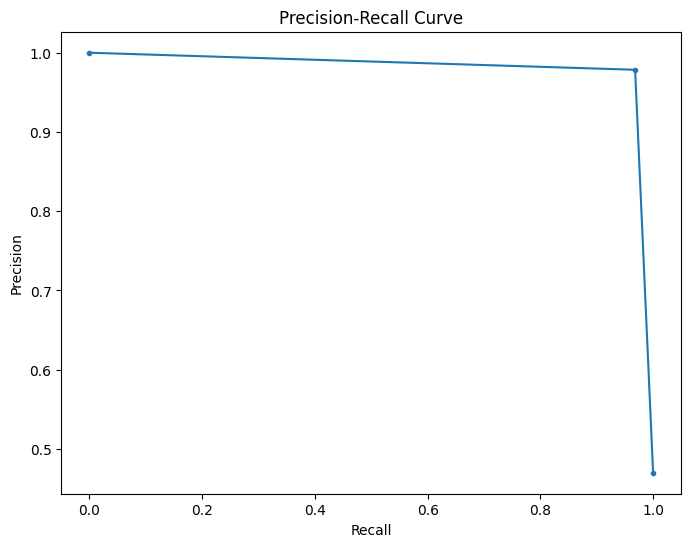

In [56]:
precision, recall, _ = precision_recall_curve(y_vi_test, y_vi_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [57]:
joblib.dump(model_vi, 'fake_news_detector_vi.pkl')
joblib.dump(vectorizer_vi, 'tfidf_vectorizer_vi.pkl')

['tfidf_vectorizer_vi.pkl']